In [1]:
import os

import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import xarray as xr
from plotting import plot_eeg_topomaps
from scipy.stats import zscore
from tqdm import tqdm
from utils import run_in_parallel

plt.style.use("papers")

DATA_FOLDER = "../../data/test_data_LEMON/"
RESULTS_FOLDER = "/Users/nikola/work-brain/eeg_microstate_and_latent_space/results/20220707_VARprocess_EC_50subjects_30.0s_segment_3600.0s_VARlength/"

# VAR orders

In [2]:
orders_raw = pd.read_csv(os.path.join(RESULTS_FOLDER, "VAR_orders_aic.csv"))
orders = []
for col in orders_raw.filter(like="sub"):
    orders.append(orders_raw[["order", col]].dropna(axis=0).set_index("order"))
orders = pd.concat(orders, axis=1)

mins = orders.idxmin()
display(mins)
display(mins.median(), mins.mean())

sub-010020_EC    10
sub-010027_EC    10
sub-010016_EC    10
sub-010010_EC    10
sub-010003_EC    10
sub-010023_EC    10
sub-010024_EC    10
sub-010038_EC    10
sub-010005_EC    10
sub-010035_EC    10
sub-010042_EC    10
sub-010044_EC    10
sub-010041_EC    10
sub-010039_EC     7
sub-010046_EC     6
sub-010051_EC     6
sub-010048_EC     8
sub-010052_EC    10
sub-010059_EC    10
sub-010063_EC    10
sub-010068_EC    10
sub-010079_EC    10
sub-010073_EC    10
sub-010071_EC    10
sub-010081_EC    10
sub-010075_EC    10
sub-010104_EC    10
sub-010090_EC    10
sub-010088_EC    10
sub-010094_EC    10
sub-010163_EC    10
sub-010155_EC    10
sub-010196_EC    10
sub-010194_EC    10
sub-010214_EC    10
sub-010239_EC     6
sub-010220_EC    10
sub-010238_EC    10
sub-010233_EC    10
sub-010244_EC    10
sub-010249_EC    10
sub-010252_EC    10
sub-010261_EC    10
sub-010257_EC    10
sub-010265_EC    10
sub-010286_EC    10
sub-010266_EC    10
sub-010316_EC    10
sub-010292_EC    10
sub-010305_EC    10


10.0

9.66

<AxesSubplot:xlabel='order', ylabel='AIC'>

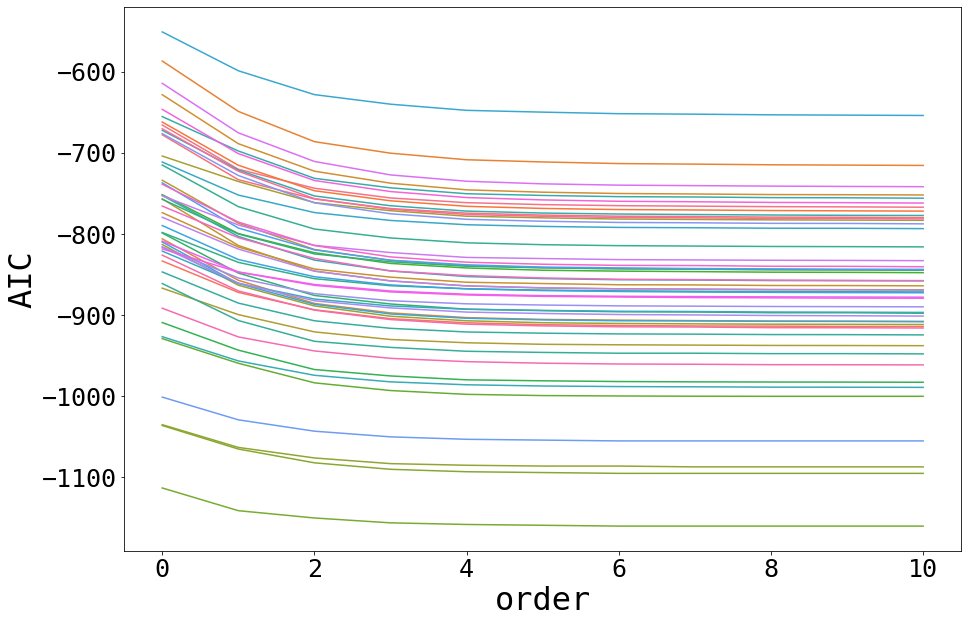

In [3]:
plt.figure(figsize=(15, 10))
sns.lineplot(
    data=orders.reset_index().melt(
        id_vars="order", value_name="AIC", var_name="subject"
    ),
    x="order",
    y="AIC",
    hue="subject",
    legend=False,
)

# Topomaps

In [4]:
topomaps = xr.open_dataarray(os.path.join(RESULTS_FOLDER, "topomaps.nc"))
topomaps = topomaps.set_index({"stack": ["subject_id", "type"]}).unstack()

/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_30237/1854914166.py:3: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
/var/folders/8l/kg7qz2vn3jn9_bzjm1p_pgq40000gn/T/ipykernel_30237/1854914166.py:3: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False


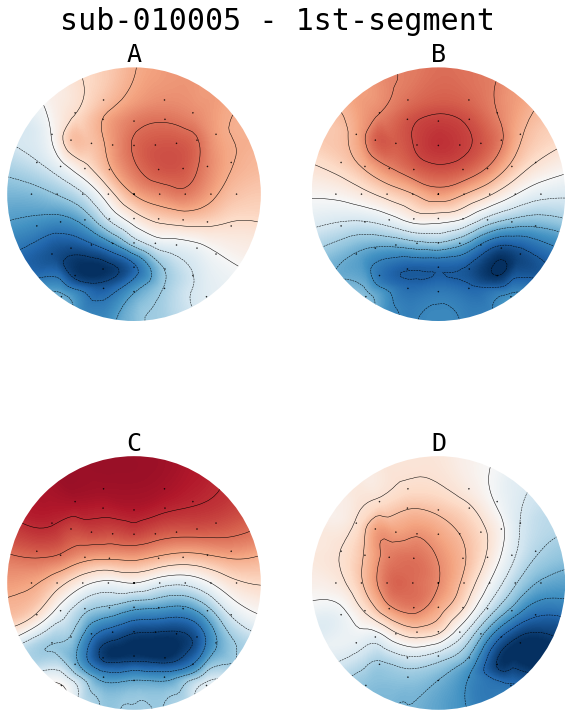

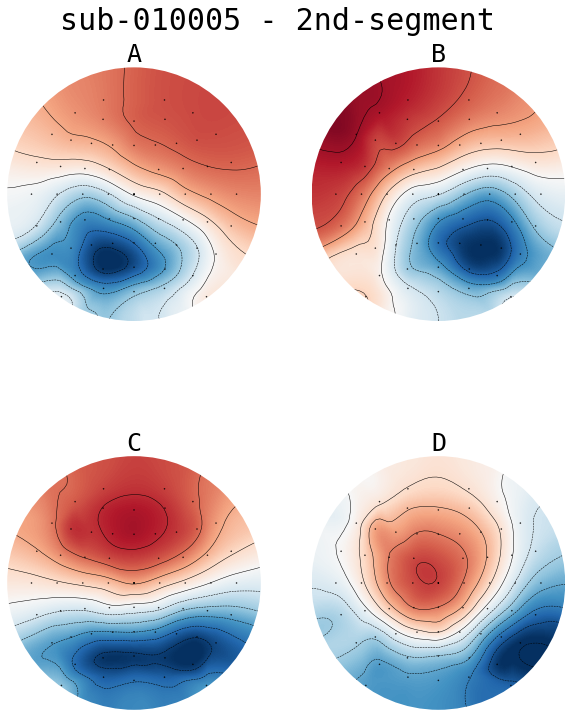

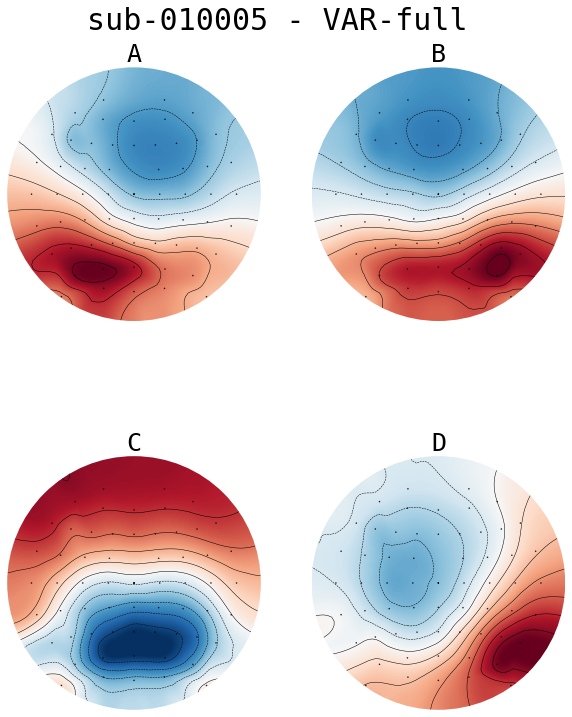

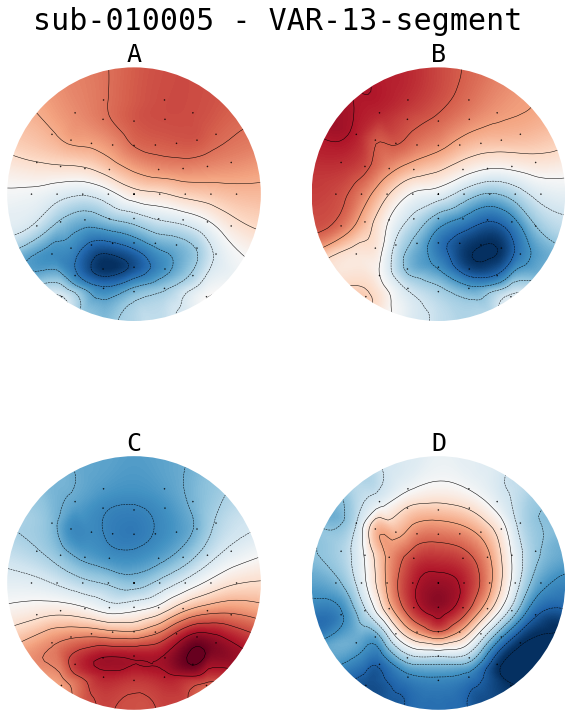

In [5]:
subj_id = "sub-010005"
subj_info = mne.io.read_raw_eeglab(
    os.path.join(DATA_FOLDER, f"{subj_id}_EC.set"), preload=False
)
PLOT_TYPES = ["1st-segment", "2nd-segment", "VAR-full", "VAR-13-segment"]

for plot_type in PLOT_TYPES:
    plot_eeg_topomaps(
        topomaps.sel({"subject_id": subj_id, "type": plot_type})
        .dropna("channels")
        .values,
        subj_info.info,
        title=subj_id + " - " + plot_type,
    )
    plt.show()

# Topomaps accordance

In [6]:
all_corrs = []
TYPES = list(topomaps["type"].values)
for typ1 in TYPES:
    for typ2 in TYPES:
        all_corrs.append(
            xr.corr(
                topomaps.sel({"type": typ1}),
                topomaps.sel({"type": typ2}),
                dim="channels",
            )
            .assign_coords({"type1": typ1, "type2": typ2})
            .expand_dims(["type1", "type2"])
        )

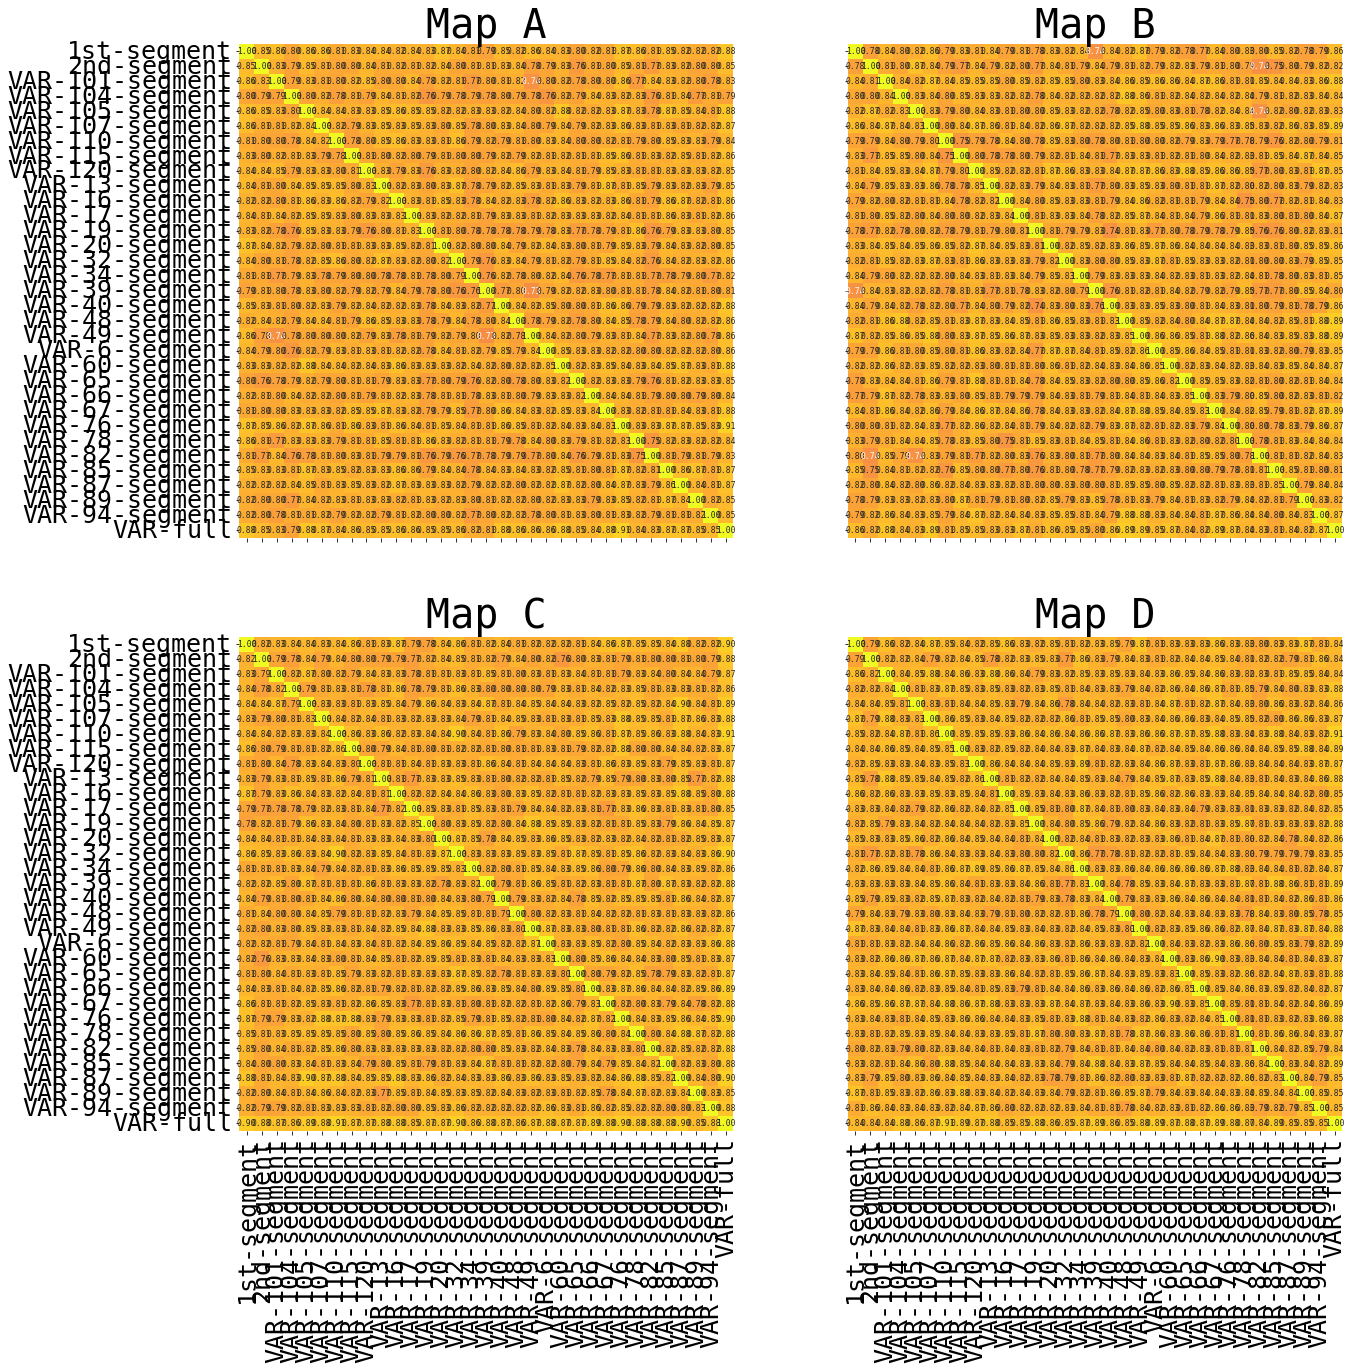

In [7]:
corrs = np.abs(xr.combine_by_coords(all_corrs))
corrs

fig, axs = plt.subplots(
    nrows=2, ncols=2, squeeze=True, figsize=(20, 20), sharey=True, sharex=True
)
axs = axs.flatten()
for i, lamap in enumerate(corrs["latent map"]):
    sns.heatmap(
        corrs.mean(dim="subject_id").sel({"latent map": lamap}),
        square=True,
        ax=axs[i],
        cbar=False,
        cmap="plasma",
        annot_kws={"size": 8},
        annot=True,
        vmin=0,
        vmax=1,
        fmt=".2f",
    )
    axs[i].set_xticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=90)
    axs[i].set_yticks(np.arange(len(TYPES)) + 0.5, TYPES, rotation=0)
    axs[i].set_title(f"Map {lamap.values}")

In [8]:
TYPES = ["1st-segment", "2nd-segment", "VAR-full"]
SUBJECTS = np.unique(topomaps.coords["subject_id"].values)


def _compute_corr(args):
    topomaps, typ1, typ2, subj1, subj2 = args
    return (
        xr.corr(
            topomaps.sel({"type": typ1, "subject_id": subj1}),
            topomaps.sel({"type": typ2, "subject_id": subj2}),
            dim="channels",
        )
        .assign_coords({"type1": typ1, "type2": typ2, "subj1": subj1, "subj2": subj2})
        .expand_dims(["type1", "type2", "subj1", "subj2"])
    )


all_corrs2 = run_in_parallel(
    _compute_corr,
    [
        (topomaps, typ1, typ2, subj1, subj2)
        for typ1 in TYPES
        for typ2 in TYPES
        for subj1 in SUBJECTS
        for subj2 in SUBJECTS
    ],
)

combined = np.abs(xr.combine_by_coords(all_corrs2))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22500/22500 [01:39<00:00, 225.20it/s]


Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

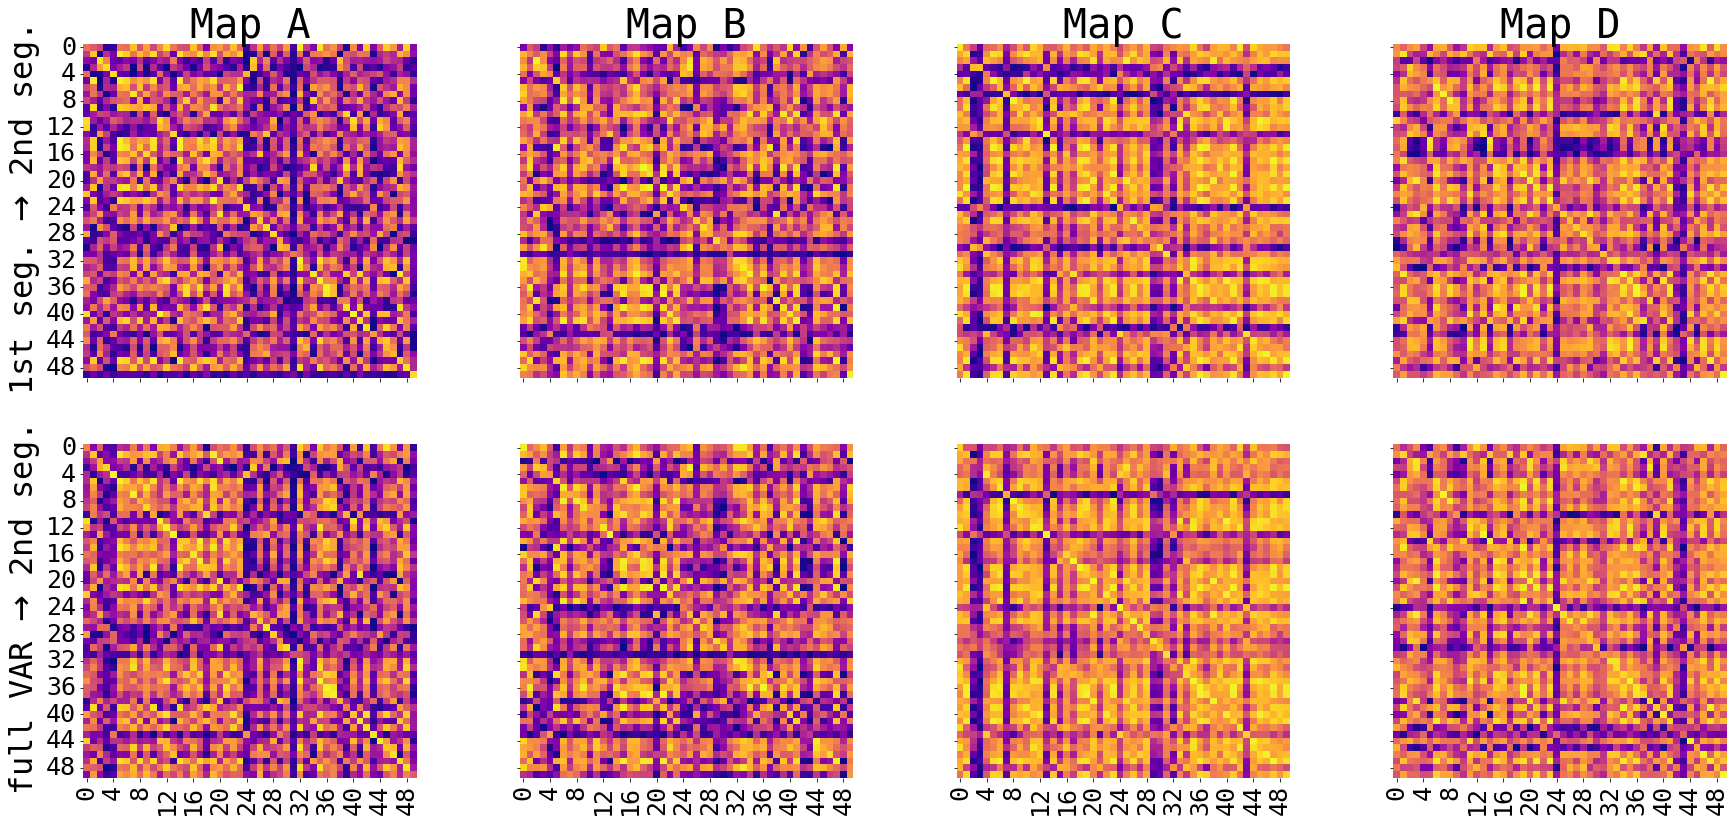

In [9]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)

for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            combined.sel({"type1": howto, "type2": "2nd-segment", "latent map": lamap}),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="plasma",
            vmin=0,
            vmax=1,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

Text(244.17015810276683, 0.5, 'full VAR $\\to$ 2nd seg.')

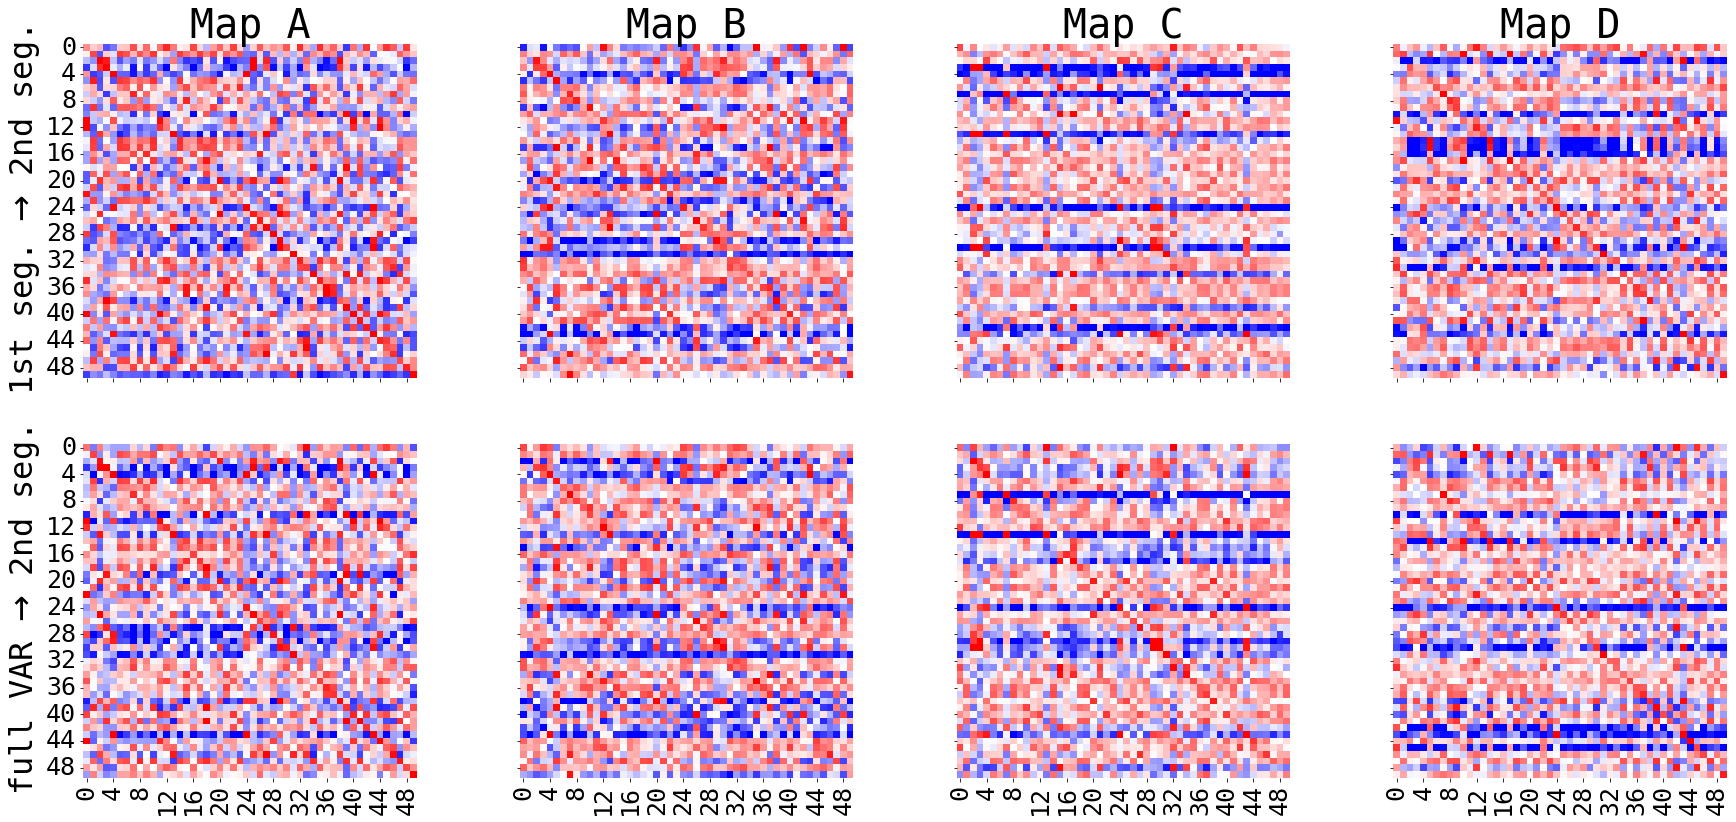

In [10]:
fig, axs = plt.subplots(
    nrows=2, ncols=4, squeeze=True, figsize=(30, 13.5), sharey=True, sharex=True
)
for i, lamap in enumerate(combined["latent map"]):
    for j, howto in enumerate(["1st-segment", "VAR-full"]):
        sns.heatmap(
            zscore(
                combined.sel(
                    {"type1": howto, "type2": "2nd-segment", "latent map": lamap}
                ).values,
                axis=0,
            ),
            square=True,
            ax=axs[j, i],
            cbar=False,
            cmap="bwr",
            vmin=-2.0,
            vmax=2.0,
        )
    axs[0, i].set_title(f"Map {lamap.values}")
axs[0, 0].set_ylabel(r"1st seg. $\to$ 2nd seg.")
axs[1, 0].set_ylabel(r"full VAR $\to$ 2nd seg.")

In [11]:
correct_classif = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif.loc[howto, str(lamap.values)] = (
            combined.sel(
                {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
            ).values.argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif)

correct_classif_zs = pd.DataFrame(
    columns=list(combined["latent map"].values), index=["1st-segment", "VAR-full"]
)

for lamap in combined["latent map"]:
    for howto in ["1st-segment", "VAR-full"]:
        correct_classif_zs.loc[howto, str(lamap.values)] = (
            zscore(
                combined.sel(
                    {"latent map": lamap, "type1": howto, "type2": "2nd-segment"}
                ).values,
                axis=0,
            ).argmax(axis=0)
            == np.arange(len(SUBJECTS))
        ).sum()

display(correct_classif_zs)

,A,B,C,D
1st-segment,23,18,15,18
VAR-full,26,18,25,17


,A,B,C,D
1st-segment,23,18,15,18
VAR-full,26,18,25,17


# Static and dynamic stats

In [12]:
static_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "static_stats.csv"), index_col=0
)
static_stats[["subject_id", "type"]] = (
    static_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
static_stats = static_stats.drop(
    ["filter", "decomposition_type", "use_gfp", "no_states"], axis=1
).sort_values(["subject_id", "type", "latent map"])
# make mean / std from VAR segments
var_means = (
    static_stats.loc[static_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id", "latent map"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

static_stats_final = pd.concat(
    [static_stats.loc[~static_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
static_stats_final = static_stats_final.set_index(["subject_id", "type", "latent map"])
static_stats_final

var_GFP  var_total  template_corr  \
subject_id type              latent map                                       
sub-010003 1st-segment       A           0.732119   0.670094       0.942027   
                             B           0.732119   0.670094       0.763071   
                             C           0.732119   0.670094       0.968080   
                             D           0.732119   0.670094       0.973606   
           2nd-segment       A           0.712786   0.659377       0.804594   
...                                           ...        ...            ...   
sub-010305 VAR-segments-mean D           0.780673   0.732671       0.801621   
sub-010316 VAR-segments-mean A           0.822076   0.753357       0.833909   
                             B           0.822076   0.753357       0.772543   
                             C           0.822076   0.753357       0.844397   
                             D           0.822076   0.753357       0.941520   

                                         coverage  occurrence   lifespan  \
subject_id type              latent map                                    
sub-010003 1st-segment       A           0.247034   12.764965  19.352480   
                             B           0.191441   11.731769  16.318182   
                             C           0.282362   11.798427  23.920904   
                             D           0.279163   13.531529  20.671605   
           2nd-segment       A           0.207306   10.698574  19.376947   
...                                           ...         ...        ...   
sub-010305 VAR-segments-mean D           0.252754   14.419255  17.532630   
sub-010316 VAR-segments-mean A           0.236627   14.938077  15.872913   
                             B           0.249937   14.125957  17.793809   
                             C           0.253203   12.776133  19.909960   
                             D           0.260233   13.107199  19.871032   

                                         transition->A  transition->B  \
subject_id type              latent map                                 
sub-010003 1st-segment       A                0.793308       0.063141   
                             B                0.090529       0.754875   
                             C                0.052433       0.047709   
                             D                0.067813       0.063992   
           2nd-segment       A                0.793569       0.084887   
...                                                ...            ...   
sub-010305 VAR-segments-mean D                0.061489       0.075047   
sub-010316 VAR-segments-mean A                0.744775       0.045238   
                             B                0.131575       0.772678   
                             C                0.050451       0.082483   
                             D                0.055676       0.096663   

                                         transition->C  transition->D  
subject_id type              latent map                                
sub-010003 1st-segment       A                0.060982       0.082569  
                             B                0.077994       0.076602  
                             C                0.832782       0.067076  
                             D                0.062082       0.806113  
           2nd-segment       A                0.061093       0.060450  
...                                                ...            ...  
sub-010305 VAR-segments-mean D                0.093184       0.770280  
sub-010316 VAR-segments-mean A                0.111147       0.098840  
                             B                0.049621       0.046126  
                             C                0.797053       0.070013  
                             D                0.049967       0.797695  

[800 rows x 10 columns]

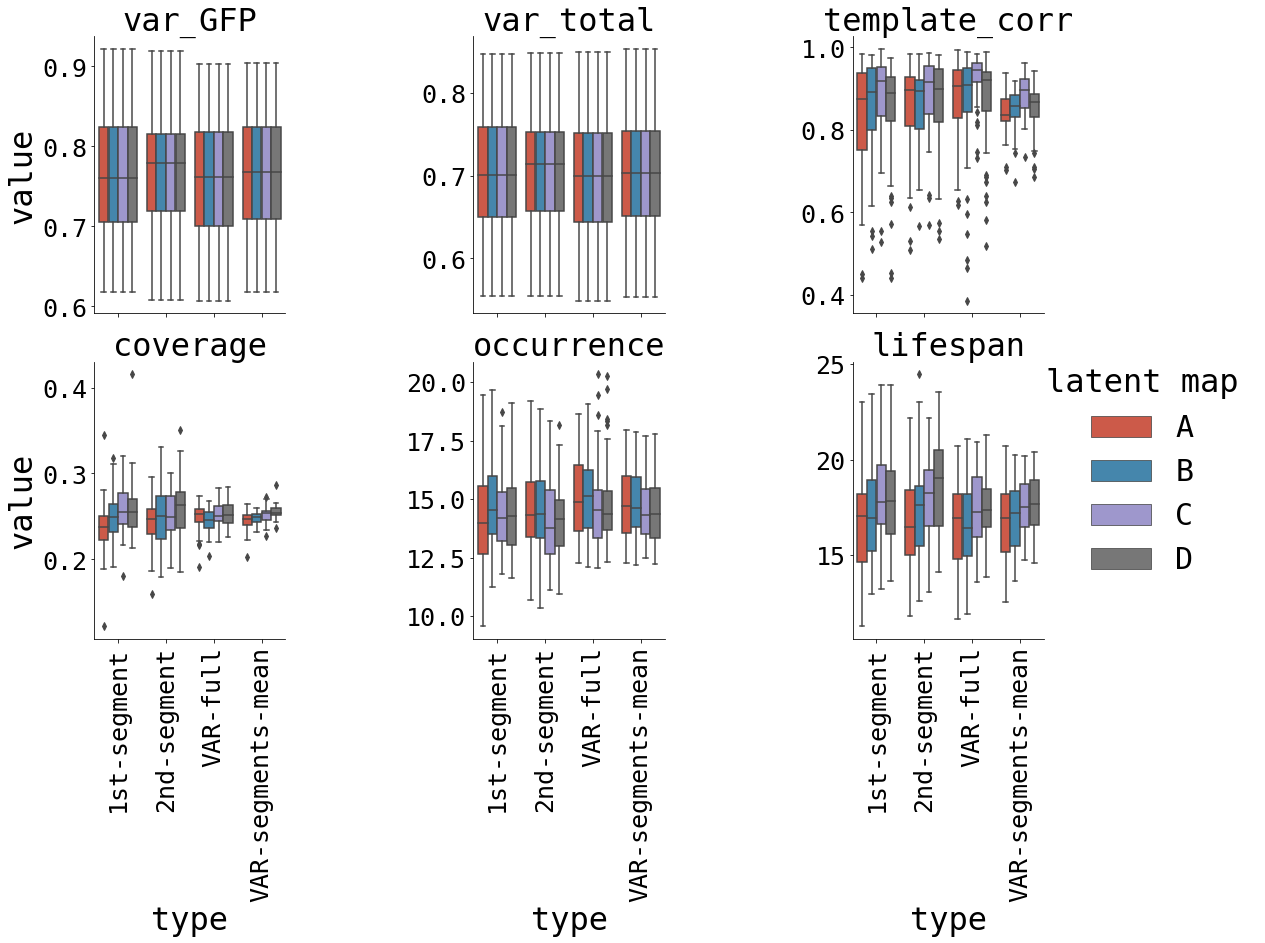

In [13]:
melt = static_stats_final.reset_index().melt(
    id_vars=["latent map", "type", "subject_id"],
    value_vars=[
        "var_GFP",
        "var_total",
        "template_corr",
        "coverage",
        "occurrence",
        "lifespan",
    ],
)
g = sns.catplot(
    data=melt,
    col="variable",
    col_wrap=3,
    hue="latent map",
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [14]:
STATS_COLS = [
    "var_GFP",
    "var_total",
    "template_corr",
    "coverage",
    "occurrence",
    "lifespan",
    "transition->A",
    "transition->B",
    "transition->C",
    "transition->D",
]

real_data_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "1st-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

var_full_diff = (
    static_stats[static_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
    - static_stats[static_stats["type"] == "VAR-full"]
    .sort_values(["subject_id", "latent map"])
    .set_index(["subject_id", "latent map"])[STATS_COLS]
)

all_segments = sorted(
    static_stats["type"][static_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        static_stats[static_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
        - static_stats[static_stats["type"] == segment]
        .sort_values(["subject_id", "latent map"])
        .set_index(["subject_id", "latent map"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id", "latent map"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
static_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [15]:
DVS = ["var_GFP", "var_total", "template_corr", "coverage", "occurrence", "lifespan"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=static_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=static_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== var_GFP ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,47.250639,4.293688e-15,0.01312,0.758929


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,13.746633,49.0,two-sided,1.938755e-18,1.066315e-17,fdr_by,2.754e+15,0.265286
1,diffs,VAR-full,real_data,True,True,6.713900,49.0,two-sided,1.841139e-08,5.063132e-08,fdr_by,7.054e+05,0.204585
2,diffs,VAR-segments,real_data,True,True,-1.708135,49.0,two-sided,9.394009e-02,1.722235e-01,fdr_by,0.593,-0.057614


== var_total ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,84.008633,5.616894e-22,0.009018,0.760217


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,18.551704,49.0,two-sided,8.414468e-24,4.627957e-23,fdr_by,4.504e+20,0.219887
1,diffs,VAR-full,real_data,True,True,8.308806,49.0,two-sided,6.466468e-11,1.778279e-10,fdr_by,1.531e+08,0.169158
2,diffs,VAR-segments,real_data,True,True,-2.473073,49.0,two-sided,1.691167e-02,3.100472e-02,fdr_by,2.4,-0.048369


== template_corr ==


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,12.666825,0.000013,0.05067,0.845039


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-5.321227,49.0,two-sided,0.000003,0.000014,fdr_by,6829.931,-0.473485
1,diffs,VAR-full,real_data,True,True,-3.973055,49.0,two-sided,0.000233,0.000640,fdr_by,106.232,-0.469389
2,diffs,VAR-segments,real_data,True,True,-0.447807,49.0,two-sided,0.656266,1.000000,fdr_by,0.169,-0.053455


== coverage ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,0.957233,0.387514,0.006603,0.694961


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.013465,49.0,two-sided,0.989311,1.000000,fdr_by,0.154,-0.001423
1,diffs,VAR-full,real_data,True,True,0.960087,49.0,two-sided,0.341725,0.939745,fdr_by,0.238,0.153625
2,diffs,VAR-segments,real_data,True,True,1.172996,49.0,two-sided,0.246468,0.939745,fdr_by,0.294,0.165499


== occurrence ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,26.110165,8.135250e-10,7.276733e-09,0.085486,0.874725,False,0.856783,0.024485


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-4.530401,49.0,two-sided,3.789176e-05,1.042024e-04,fdr_by,558.978,-0.411827
1,diffs,VAR-full,real_data,True,True,-6.158205,49.0,two-sided,1.334383e-07,7.339106e-07,fdr_by,1.086e+05,-0.696625
2,diffs,VAR-segments,real_data,True,True,-3.509415,49.0,two-sided,9.734689e-04,1.784693e-03,fdr_by,29.173,-0.344042


== lifespan ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,25.30001,1.384054e-09,1.226164e-07,0.083717,0.736263,False,0.641789,0.000024


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,5.092688,49.0,two-sided,5.625016e-06,0.000015,fdr_by,3267.177,0.361357
1,diffs,VAR-full,real_data,True,True,5.887055,49.0,two-sided,3.492177e-07,0.000002,fdr_by,4.393e+04,0.697730
2,diffs,VAR-segments,real_data,True,True,3.560935,49.0,two-sided,8.336571e-04,0.001528,fdr_by,33.524,0.381470


In [16]:
dynamic_stats = pd.read_csv(
    os.path.join(RESULTS_FOLDER, "dynamic_stats.csv"), index_col=0
)
dynamic_stats[["subject_id", "type"]] = (
    dynamic_stats["subject_id"].str.split("_", expand=True).drop([1], axis=1)
)
dynamic_stats = dynamic_stats.sort_values(["subject_id", "type"])
# make mean / std from VAR segments
var_means = (
    dynamic_stats.loc[dynamic_stats["type"].str.match("VAR-\d*-segment")]
    .groupby(["subject_id"])
    .mean()
    .reset_index()
)
var_means["type"] = "VAR-segments-mean"

dynamic_stats_final = pd.concat(
    [dynamic_stats.loc[~dynamic_stats["type"].str.match("VAR-\d*-segment")], var_means],
    axis=0,
)
dynamic_stats_final = dynamic_stats_final.set_index(["subject_id", "type"])
dynamic_stats_final

mixing time   entropy  max entropy  \
subject_id type                                                    
sub-010003 1st-segment           4.309242  1.983939          2.0   
           2nd-segment           3.910367  1.967925          2.0   
           VAR-full              3.924957  1.998062          2.0   
sub-010005 1st-segment           3.711872  1.982976          2.0   
           2nd-segment           3.951871  1.996516          2.0   
...                                   ...       ...          ...   
sub-010266 VAR-segments-mean     3.467396  1.993193          2.0   
sub-010286 VAR-segments-mean     3.407124  1.988723          2.0   
sub-010292 VAR-segments-mean     3.669889  1.992710          2.0   
sub-010305 VAR-segments-mean     3.571257  1.993957          2.0   
sub-010316 VAR-segments-mean     3.932591  1.993472          2.0   

                              entropy_rate  MC entropy rate  AIF 1st peak  
subject_id type                                                            
sub-010003 1st-segment            0.990483         1.031631     52.000000  
           2nd-segment            0.955997         0.996976     52.000000  
           VAR-full               1.020691         1.042062     56.000000  
sub-010005 1st-segment            0.998968         1.040522     60.000000  
           2nd-segment            0.968170         1.004476     56.000000  
...                                    ...              ...           ...  
sub-010266 VAR-segments-mean      1.073972         1.120426     49.333333  
sub-010286 VAR-segments-mean      1.115516         1.172117     52.000000  
sub-010292 VAR-segments-mean      1.054112         1.101794     51.866667  
sub-010305 VAR-segments-mean      1.039504         1.088515     52.266667  
sub-010316 VAR-segments-mean      1.020648         1.069396     51.200000  

[200 rows x 6 columns]

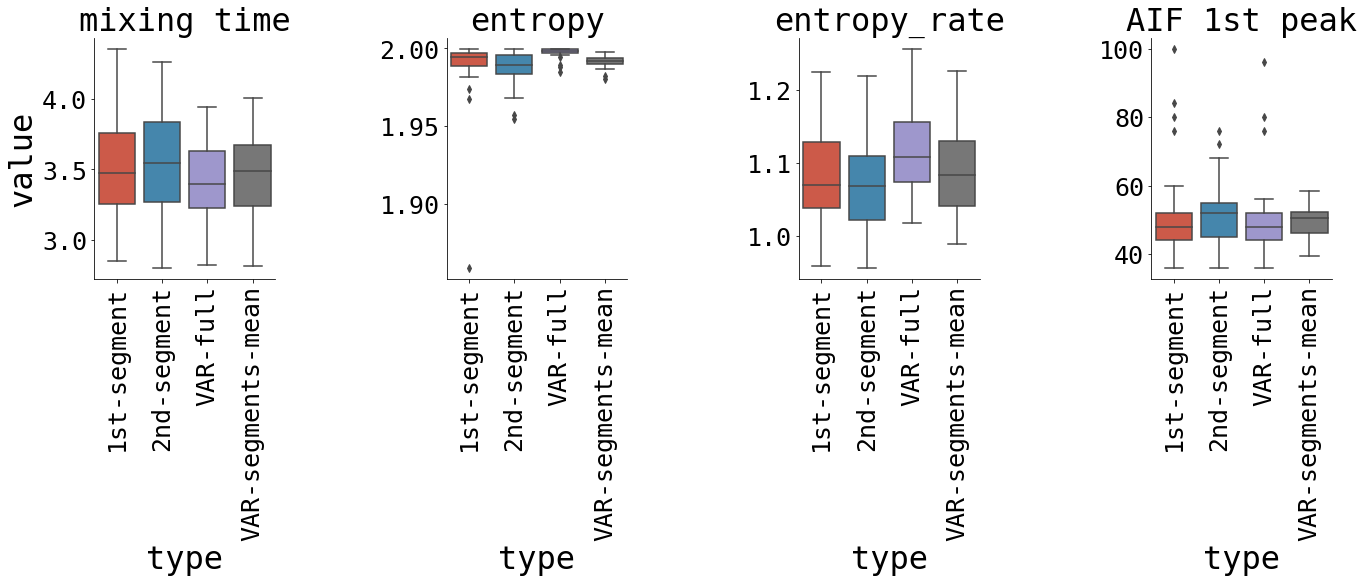

In [17]:
g = sns.catplot(
    data=dynamic_stats_final.reset_index().melt(
        id_vars=["subject_id", "type"],
        value_vars=["mixing time", "entropy", "entropy_rate", "AIF 1st peak"],
    ),
    col="variable",
    col_wrap=4,
    x="type",
    y="value",
    kind="box",
    sharey=False,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels(rotation=90)

In [18]:
dynamic_stats

,subject_id,mixing time,entropy,max entropy,entropy_rate,MC entropy rate,AIF 1st peak,type
0,sub-010003,4.309242,1.983939,2.0,0.990483,1.031631,52.0,1st-segment
0,sub-010003,3.910367,1.967925,2.0,0.955997,0.996976,52.0,2nd-segment
0,sub-010003,4.108991,1.988494,2.0,0.984576,1.024259,56.0,VAR-101-segment
0,sub-010003,3.919431,1.995081,2.0,0.997351,1.039552,56.0,VAR-104-segment
0,sub-010003,3.942938,1.998873,2.0,0.978598,1.020725,56.0,VAR-105-segment
...,...,...,...,...,...,...,...,...
0,sub-010316,4.136524,1.991626,2.0,1.010163,1.061996,52.0,VAR-85-segment
0,sub-010316,4.070800,1.996067,2.0,1.026219,1.075413,48.0,VAR-87-segment
0,sub-010316,3.856076,1.998321,2.0,1.026798,1.073900,52.0,VAR-89-segment
0,sub-010316,3.875874,1.994859,2.0,1.020357,1.065706,52.0,VAR-94-segment


In [19]:
STATS_COLS = [
    "mixing time",
    "entropy",
    "entropy_rate",
    "AIF 1st peak",
]

real_data_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "1st-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

var_full_diff = (
    dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
    - dynamic_stats[dynamic_stats["type"] == "VAR-full"]
    .sort_values(["subject_id"])
    .set_index(["subject_id"])[STATS_COLS]
)

all_segments = sorted(
    dynamic_stats["type"][dynamic_stats["type"].str.match(r"VAR-\d*-segment")].unique()
)
all_segments_diffs = []
for segment in all_segments:
    df_temp = (
        dynamic_stats[dynamic_stats["type"] == "2nd-segment"]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
        - dynamic_stats[dynamic_stats["type"] == segment]
        .sort_values(["subject_id"])
        .set_index(["subject_id"])[STATS_COLS]
    )
    df_temp["segment"] = segment
    all_segments_diffs.append(df_temp)
all_segments_diffs = pd.concat(all_segments_diffs)
var_segments_diff_mean = (
    all_segments_diffs.reset_index().groupby(["subject_id"]).mean()
)

real_data_diff["diffs"] = "real_data"
var_full_diff["diffs"] = "VAR-full"
var_segments_diff_mean["diffs"] = "VAR-segments"
dynamic_diffs = pd.concat([real_data_diff, var_full_diff, var_segments_diff_mean]).reset_index()

In [20]:
dynamic_diffs

,subject_id,mixing time,entropy,entropy_rate,AIF 1st peak,diffs
0,sub-010003,-0.398875,-0.016014,-0.034486,0.000000,real_data
1,sub-010005,0.239999,0.013540,-0.030798,-4.000000,real_data
2,sub-010010,0.137120,-0.002519,-0.011204,4.000000,real_data
3,sub-010016,-0.285185,0.004173,0.016645,0.000000,real_data
4,sub-010020,0.037012,0.002408,0.006075,-4.000000,real_data
...,...,...,...,...,...,...
145,sub-010266,-0.060286,-0.004603,-0.006469,6.666667,VAR-segments
146,sub-010286,0.287830,0.007658,-0.030598,0.000000,VAR-segments
147,sub-010292,0.146991,0.006512,-0.030257,-3.866667,VAR-segments
148,sub-010305,0.477433,-0.004653,-0.052917,3.733333,VAR-segments


In [21]:
DVS = ["mixing time", "entropy", "entropy_rate", "AIF 1st peak"]

for dv in DVS:
    print(f"== {dv} ==")
    display(pg.rm_anova(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id"))
    display(pg.pairwise_ttests(data=dynamic_diffs, dv=dv, within="diffs", subject="subject_id", padjust="fdr_by"))

== mixing time ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,10.902109,0.000053,0.000734,0.050462,0.626295,False,0.403307,3.429789e-10


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,4.944128,49.0,two-sided,0.000009,0.000052,fdr_by,2034.345,0.311358
1,diffs,VAR-full,real_data,True,True,3.918972,49.0,two-sided,0.000276,0.000759,fdr_by,90.95,0.525683
2,diffs,VAR-segments,real_data,True,True,1.983193,49.0,two-sided,0.052965,0.097103,fdr_by,0.933,0.264396


== entropy ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,6.181125,0.002964,0.048618,0.519395


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-12.837957,49.0,two-sided,2.707773e-17,1.489275e-16,fdr_by,2.138e+14,-0.589533
1,diffs,VAR-full,real_data,True,True,-2.701897,49.0,two-sided,9.444515e-03,2.597242e-02,fdr_by,3.947,-0.456833
2,diffs,VAR-segments,real_data,True,True,-0.641902,49.0,two-sided,5.239284e-01,9.605354e-01,fdr_by,0.187,-0.105872


== entropy_rate ==


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/distribution.py:977: RuntimeWarning: divide by zero encountered in double_scalars
  W = np.product(eig) / (eig.sum() / d) ** d


,Source,ddof1,ddof2,F,p-unc,ng2,eps
0,diffs,2,98,118.468898,7.028035e-27,0.33672,0.570342


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-29.639608,49.0,two-sided,5.976940e-33,3.287317e-32,fdr_by,3.825e+29,-1.388961
1,diffs,VAR-full,real_data,True,True,-11.861177,49.0,two-sided,5.181477e-16,1.424906e-15,fdr_by,1.228e+13,-1.557377
2,diffs,VAR-segments,real_data,True,True,-3.101836,49.0,two-sided,3.187609e-03,5.843950e-03,fdr_by,10.168,-0.380413


== AIF 1st peak ==


,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,diffs,2,98,0.420476,0.657913,0.592964,0.003041,0.723534,False,0.617895,0.00001


/Users/nikola/.virtualenvs/eeg_latent/lib/python3.7/site-packages/pingouin/pairwise.py:27: UserWarning: pairwise_ttests is deprecated, use pairwise_tests instead.
  warnings.warn("pairwise_ttests is deprecated, use pairwise_tests instead.", UserWarning)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,diffs,VAR-full,VAR-segments,True,True,-0.196480,49.0,two-sided,0.845047,1.0,fdr_by,0.157,-0.026344
1,diffs,VAR-full,real_data,True,True,0.556304,49.0,two-sided,0.580535,1.0,fdr_by,0.178,0.089912
2,diffs,VAR-segments,real_data,True,True,0.975589,49.0,two-sided,0.334060,1.0,fdr_by,0.241,0.125266
